# Preprocessing

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras import Model

tf.__version__

'2.12.0'

In [8]:
SLICE_DURATION = 0.5
SAMPLING_RATE = 22500
N_FFT = 2048
HOP_LENGTH = N_FFT // 4
N_MELS=512
MEL_MIN_HZ = 0
MEL_MAX_HZ = SAMPLING_RATE / 2

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
N_KERNELS = 10
N_FILTERS = 1

N_EPOCHS = 10

In [9]:
window_length_samples = int(round(SAMPLING_RATE * SLICE_DURATION))
fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
hop_length = fft_length // 64

window_length_samples, hop_length

(11250, 256)

In [10]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [11]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [12]:
random_slice = slices[np.random.randint(len(slices))]

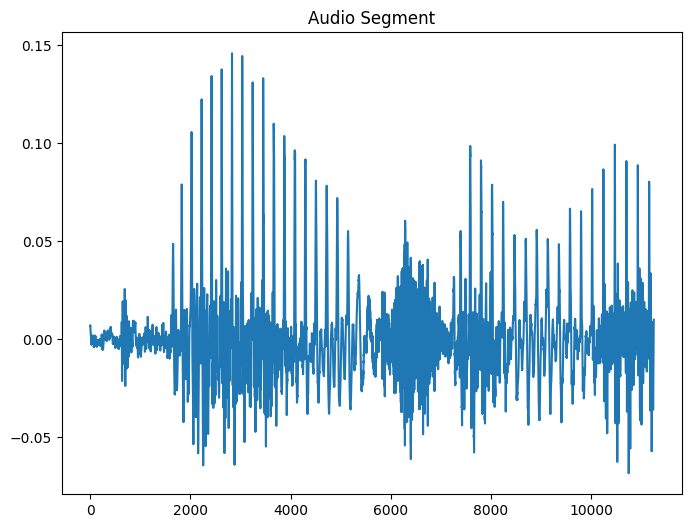

In [13]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [14]:
def get_stft(audio_slice):
    window = np.hanning(N_FFT)
    spectrogram = librosa.stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH, window=window)
    return np.abs(spectrogram)

In [15]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

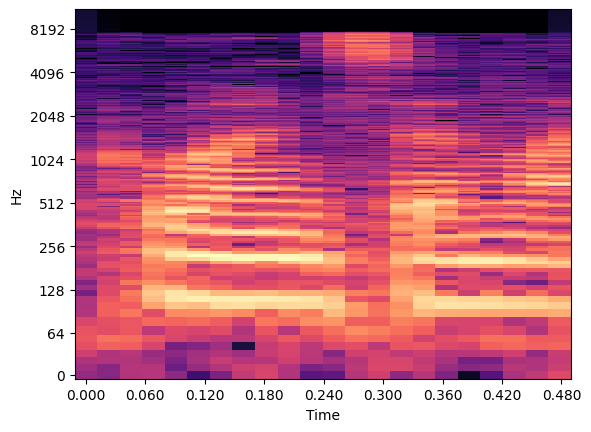

In [16]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [17]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [18]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((11, 1025, 22),
 array([[5.02947867e-01, 2.19858512e-01, 3.77123281e-02, ...,
         7.71464482e-02, 1.01851955e-01, 2.32145220e-01],
        [5.34973085e-01, 2.71615654e-01, 9.31592360e-02, ...,
         8.78039226e-02, 1.54426247e-01, 1.01530790e-01],
        [5.24474740e-01, 3.18895251e-01, 5.26576377e-02, ...,
         1.01958796e-01, 1.83697298e-01, 1.01138003e-01],
        ...,
        [7.63271237e-04, 3.80949525e-04, 4.57426008e-09, ...,
         2.21606467e-08, 2.87624317e-07, 3.65803397e-04],
        [7.63264892e-04, 3.80946818e-04, 1.13606555e-08, ...,
         3.72259699e-08, 3.18645874e-07, 3.65813845e-04],
        [7.63264252e-04, 3.80952901e-04, 7.45510376e-10, ...,
         2.67282729e-08, 2.79892220e-07, 3.65794229e-04]], dtype=float32))

In [19]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(1025, 22)

# Create Train and Test Splits

In [20]:
male_voice_dir = "males"
female_voice_dir = "females"

In [21]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [22]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [23]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Models

## STFT Based Model

In [24]:
def audio_preprocess_stft(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_stfts, labels

In [71]:
def set_tensor_shapes_stft(slice_data, label):
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [72]:
train_dataset_stft = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_stft = train_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_stft = train_dataset_stft.map(set_tensor_shapes_stft)

train_dataset_stft = train_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [73]:
val_dataset_stft = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_stft = val_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_stft = val_dataset_stft.map(set_tensor_shapes_stft)

val_dataset_stft = val_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [74]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn_stft = Model(inputs, outputs)

In [75]:
model_cnn_stft.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
history_cnn_stft = model_cnn_stft.fit(train_dataset_stft,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_stft)

Epoch 1/10
568/568 [==============================] - 112s 48ms/step - loss: 0.4999 - accuracy: 0.7895 - val_loss: 0.4862 - val_accuracy: 0.8200
Epoch 2/10
568/568 [==============================] - 18s 31ms/step - loss: 0.4277 - accuracy: 0.8296 - val_loss: 0.4610 - val_accuracy: 0.8269
Epoch 3/10
568/568 [==============================] - 18s 31ms/step - loss: 0.3962 - accuracy: 0.8389 - val_loss: 0.4353 - val_accuracy: 0.8314
Epoch 4/10
568/568 [==============================] - 18s 31ms/step - loss: 0.3798 - accuracy: 0.8442 - val_loss: 0.4238 - val_accuracy: 0.8325
Epoch 5/10
568/568 [==============================] - 18s 31ms/step - loss: 0.3700 - accuracy: 0.8482 - val_loss: 0.4158 - val_accuracy: 0.8344
Epoch 6/10
568/568 [==============================] - 18s 31ms/step - loss: 0.3614 - accuracy: 0.8518 - val_loss: 0.4042 - val_accuracy: 0.8361
Epoch 7/10
568/568 [==============================] - 18s 31ms/step - loss: 0.3562 - accuracy: 0.8536 - val_loss: 0.3975 - val_accuracy

In [77]:
model_cnn_stft.evaluate(val_dataset_stft)

65/65 [==============================] - 1s 8ms/step - loss: 0.3905 - accuracy: 0.8414


[0.3904653787612915, 0.8413549661636353]

## Mel Spectogram Based Model

In [25]:
def get_mel_spec(audio_slice):
    return librosa.feature.melspectrogram(y=audio_slice, sr=SAMPLING_RATE, n_mels=N_MELS, fmax=MEL_MAX_HZ)


In [26]:
def plot_mel_spec(mel_spec, sampling_rate=SAMPLING_RATE, f_max=MEL_MAX_HZ):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        spec_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=f_max,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

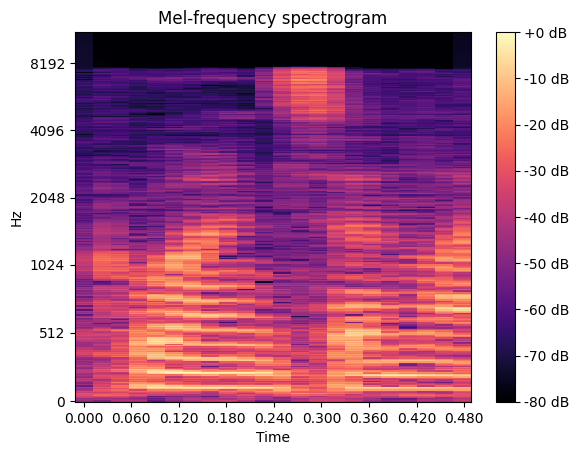

In [27]:
mel_spec = get_mel_spec(random_slice)
plot_mel_spec(mel_spec)

In [28]:
def get_audio_slices_mel_spec(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_mel_spec(audio_slice) for audio_slice in audio_slices])

In [29]:
mel_spec = get_audio_slices_mel_spec("males/0.wav")
mel_spec.shape, mel_spec[0]

((11, 512, 22),
 array([[1.38681298e-02, 3.56825162e-03, 4.21102886e-04, ...,
         3.74382129e-04, 1.15622592e-03, 4.99480695e-04],
        [3.00059393e-02, 7.72048905e-03, 9.11124167e-04, ...,
         8.10036203e-04, 2.50168168e-03, 1.08070718e-03],
        [2.66553275e-02, 9.84597392e-03, 2.68468226e-04, ...,
         1.01096765e-03, 3.26847495e-03, 9.92887653e-04],
        ...,
        [5.30255555e-08, 1.31886422e-08, 3.43548331e-16, ...,
         1.22672407e-16, 1.08028617e-14, 1.22216068e-08],
        [5.30232214e-08, 1.31882256e-08, 2.67452877e-16, ...,
         1.33465155e-16, 1.08462374e-14, 1.22271162e-08],
        [5.30275841e-08, 1.31893065e-08, 9.38436802e-17, ...,
         9.26286644e-17, 1.08411603e-14, 1.22319621e-08]], dtype=float32))

In [30]:
MEL_SPEC_SHAPE = mel_spec.shape[-2:]
MEL_SPEC_SHAPE

(512, 22)

In [31]:
def audio_preprocess_mel_spec(file_path, label):
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([tf.expand_dims(slice_mel_spec, -1) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [32]:
def set_tensor_shapes_mel_spec(slice_data, label):
    slice_data.set_shape(MEL_SPEC_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [33]:
train_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_mel_spec = train_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_mel_spec = train_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

train_dataset_mel_spec = train_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [34]:
val_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_mel_spec = val_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_mel_spec = val_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

val_dataset_mel_spec = val_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [35]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_mel_spec = Model(inputs, outputs)

In [36]:
model_cnn_mel_spec.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
history_cnn_mel_spec = model_cnn_mel_spec.fit(train_dataset_mel_spec,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_mel_spec)

Epoch 1/10


2023-06-14 21:36:36.478485: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 604s 131ms/step - loss: 0.5753 - accuracy: 0.7116 - val_loss: 0.4880 - val_accuracy: 0.7904
Epoch 2/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4510 - accuracy: 0.8051 - val_loss: 0.4654 - val_accuracy: 0.8070
Epoch 3/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4346 - accuracy: 0.8123 - val_loss: 0.4681 - val_accuracy: 0.8120
Epoch 4/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4210 - accuracy: 0.8189 - val_loss: 0.4519 - val_accuracy: 0.8187
Epoch 5/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4102 - accuracy: 0.8247 - val_loss: 0.4429 - val_accuracy: 0.8208
Epoch 6/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4128 - accuracy: 0.8235 - val_loss: 0.4724 - val_accuracy: 0.8186
Epoch 7/10
568/568 [==============================] - 10s 17ms/step - loss: 0.4017 - accuracy: 0.8287 - val_loss: 0.4361 - val_accuracy: 0.8241
E

In [38]:
model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

65/65 [==============================] - 0s 5ms/step - loss: 0.4366 - accuracy: 0.8293


[0.43663692474365234, 0.8292920589447021]